# Desafío - Expansiones basales.
### Nombre: Thomas Peet, Braulio Aguila, Camilo Ramírez
### Generación: G47
### Profesores: Alfonso Tobar - Sebastián Ulloa
### Fecha: 21-08-2022

### Descripción  

- Una aplicación interesante de los modelos predictivos es poder predecir propiedades  
de materiales compuestos a partir de diferentes combinaciones en el proceso y  
creación de estos.  
- Para este desafío trabajaremos con un dataset que contiene diferentes medidas de  
materiales con los que se hace la mezcla de concreto.  
-  Nuestra tarea será utilizar estas medidas para predecir la capacidad de resistir  
fuerzas compresivas de vigas de concreto, a esta capacidad de soportar fuerzas que  
buscan reducir la superficie o volumen de un cuerpo se le conoce como fuerza  
compresiva  

### Ejercicio 1: Preparar el ambiente de trabajo
- Importe los módulos clásicos del trabajo en ciencia de datos.  
- El archivo tiene el nombre compresive_strength_concrete.csv. Importe y genere  
estadísticas descriptivas.  
- En esta actividad su tarea será predecir la fuerza compresiva del concreto a partir de  
las medidas en la mezcla, para esto, utilice un modelo aditivo generalizado de la  
librería pyGAM.  

In [2]:
#Se importan los módulos de trabajo:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels as sm
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, recall_score, f1_score, precision_score, plot_roc_curve, RocCurveDisplay, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline

from pygam import GAM, LinearGAM
from pygam import GAM, s, te
#librería para análisis exploratorio
#import pandas_profiling
#from pandas_profiling import ProfileReport

import sys
sys.path.append("..")
import helpers as hp

In [3]:
#Se carga la data y se hace una exploración preliminar de los datos
df = pd.read_csv('compresive_strength_concrete.csv')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

### Ejercicio 2: Descripción
- El vector objetivo tiene el nombre de Concrete compressive strength(MPa,  
megapascals)  
- Los nombres de las variables son muy poco amigables, dado que contienen  
espacios, paréntesis y otros elementos difíciles de referenciar. Se sugiere (pero no se  
obliga) renombrar las variables o acceder a éstas mediante notación de índice iloc.  
- Inspeccione el tipo de datos de la base de datos, fijándose en su naturaleza y  
distribución. Decide si es necesario normalizarlos/escalarlos.  

In [6]:
## Se renombran las variables según indicación del enunciado:
rename_variables = {
    "Cement (component 1)(kg in a m^3 mixture)": "cemento",
    "Blast Furnace Slag (component 2)(kg in a m^3 mixture)" : "blast_furnace_slag",
    "Fly Ash (component 3)(kg in a m^3 mixture)" : "ceniza_volatil",
    "Water  (component 4)(kg in a m^3 mixture)": "agua",
    "Superplasticizer (component 5)(kg in a m^3 mixture)" : "superplasticidad",
    "Coarse Aggregate  (component 6)(kg in a m^3 mixture)" : "agregado_grueso",
    "Fine Aggregate (component 7)(kg in a m^3 mixture)" : "agregado_fino",
    "Age (day)" : "edad",
    "Concrete compressive strength(MPa, megapascals) " : "concrete_compressive_strength",
}
df.rename(columns=rename_variables, inplace=True)
df.drop(columns = ['agua'], inplace=True)
#Además, como se verifica más abajo (pandas profilling), se retira la variable "agua", debido a su alta correlación

In [18]:
#Inspección de los datos, vector objetivo (concrete compressive strength) y variables predictoras:
hp.describe_variables(df)

------------------------------------------------------------
-------------------Variables Categóricas--------------------
------------------------------------------------------------
------------------------------------------------------------
-------------------Variables Numéricas----------------------
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
cemento,1030.0,281.2,104.5,102.0,192.4,272.9,350.0,540.0
blast_furnace_slag,1030.0,73.9,86.3,0.0,0.0,22.0,142.9,359.4
ceniza_volatil,1030.0,54.2,64.0,0.0,0.0,0.0,118.3,200.1
superplasticidad,1030.0,6.2,6.0,0.0,0.0,6.4,10.2,32.2
agregado_grueso,1030.0,972.9,77.8,801.0,932.0,968.0,1029.4,1145.0
agregado_fino,1030.0,773.6,80.2,594.0,731.0,779.5,824.0,992.6
edad,1030.0,45.7,63.2,1.0,7.0,28.0,56.0,365.0
concrete_compressive_strength,1030.0,35.8,16.7,2.3,23.7,34.4,46.1,82.6


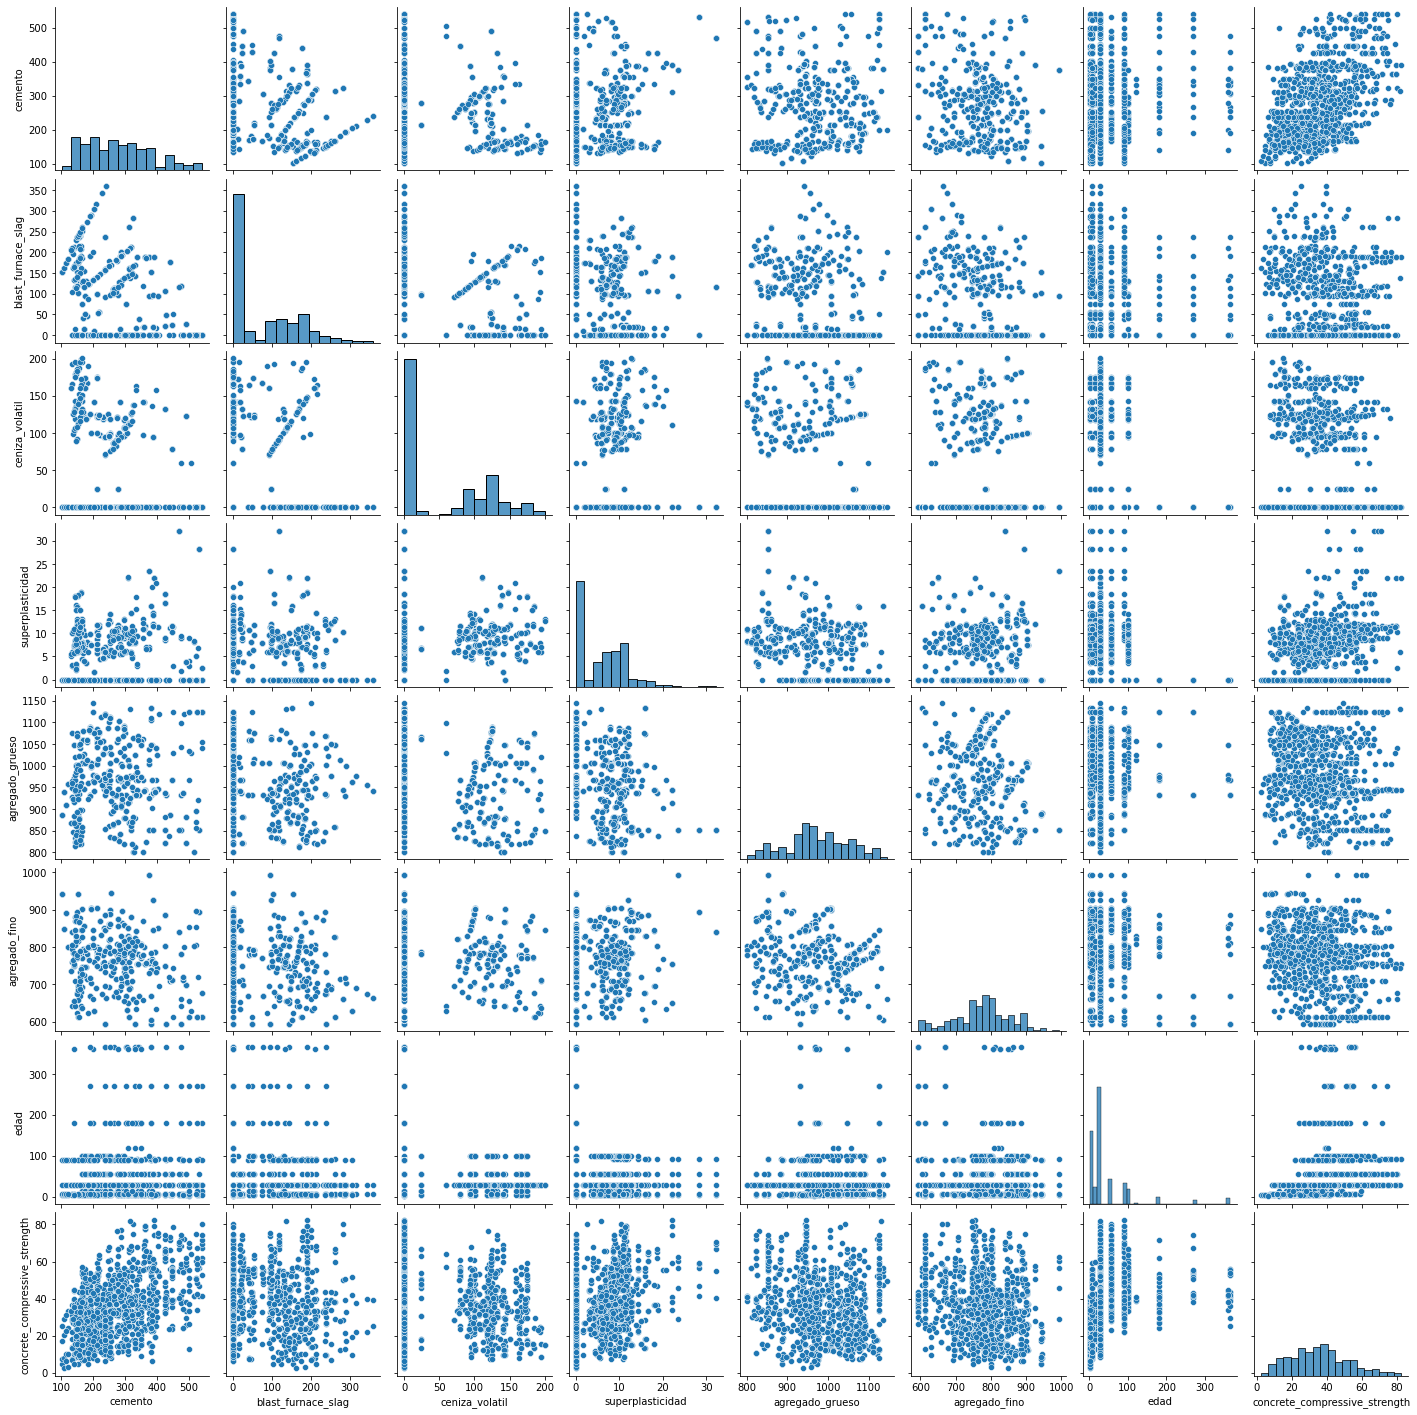

In [70]:
#Evaluamos correlación entre variables:
sns.pairplot(df)

#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_notebook_iframe()

Al inspeccionar las variables, es posible ver que se trata de variables númericas, tanto el vector objetivo como las varibles predictoras, por lo que la problemática    
se puede resolver a través de una modelación por **regresión lineal**. Asimismo, al ser variables númericas se procede a escalar.    

In [7]:
#Antes de escalar, se separa la data:
X = df.drop(columns = ["concrete_compressive_strength"])
y = df.concrete_compressive_strength

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [8]:
#Se procede a escalar la data:

# pre-processing transformers:
#Al no haber variables categóricas, no haremos encoding.
#Al no haber valores nulos, no haremos imputación.
#Al haber variables númercias, se procede a escalar.

sc = SklearnTransformerWrapper(transformer = StandardScaler(), variables = X_train.columns.to_list())
sc.fit(X_train,y_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)


### Ejercicio 3: Modelo    
- En base al vector objetivo, decida el mejor modelo e importe con pygam. Condicional a esto, importe las métricas de desempeño asociadas.      
- Genere conjuntos de entrenamiento y validación.     
- Genere un primer modelo sin implementar la función gridsearch. Reporte el hiperparámetro lam así como las métricas de desempeño asociadas.      
- Genere un segundo modelo implementando gridsearch en lambda con un logspace entre -3 y 3. Comente sobre el mejor hiper parámetro y sus métricas de desempeño.    

Como se indico anteriormente, el vector es objetivo es númerico al igual que las variables predictoras, por lo tanto se va a utilizar un modelo aditivo generalizado
lineal (LinearGAM).

In [9]:
# Modelo sin regularización (Probablemente sobreajuste)
gam_sin_reg = LinearGAM().fit(X_train, y_train)
gam_sin_reg.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     70.9491
Link Function:                     IdentityLink Log Likelihood:                                 -3113.7795
Number of Samples:                          721 AIC:                                             6371.4571
                                                AICc:                                            6387.6553
                                                GCV:                                               35.7784
                                                Scale:                                             29.5026
                                                Pseudo R-Squared:                                   0.9057
Feature Function                  Lam

C:\Users\Braulio\AppData\Local\Temp/ipykernel_3304/2671182009.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_sin_reg.summary()


In [13]:
# Modelo con regularización (Probablemente subajuste)
# gam = LinearGAM(s(0) + s(1) + s(2)+ s(3) + s(4) + s(5) + s(6) + s(7), fit_intercept=True) # 8 vars
gam = LinearGAM(s(0) + s(1) + s(2)+ s(3) + s(4) + s(5) + s(6), fit_intercept=True)

lam = np.logspace(-3,3,3)
lams = [lam] * len(X_train.columns)

lams
gam.gridsearch(X_train.values, y_train.values, lam=lams, progress=False)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     87.8666
Link Function:                     IdentityLink Log Likelihood:                                 -3036.4767
Number of Samples:                          721 AIC:                                             6250.6866
                                                AICc:                                            6275.9939
                                                GCV:                                                33.789
                                                Scale:                                             26.4684
                                                Pseudo R-Squared:                                   0.9176
Feature Function                  Lam

C:\Users\Braulio\AppData\Local\Temp/ipykernel_3304/3908377563.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [14]:
gam_scores = hp.report_regression_metrics(gam, X_test, y_test)
gam_sin_reg_scores = hp.report_regression_metrics(gam_sin_reg, X_test, y_test)

models = {'gam':gam_scores,'gam_sin_reg':gam_sin_reg_scores}
hp.reporte_modelos(models)



Models,r2_score,rmse,mae
gam,0.8570,6.2280,3.8650
gam_sin_reg,0.8550,6.2620,4.1640


De acuerdo con las métricas reportadas en la tabla anterior, se elige el modelo regularizado (gam), ya que evidencia  
una mejor performance que el modelo sin regularizar (mejor r2_score y mae más bajo,rmse muy similares)  

In [20]:
#Reporte del hiperparámetro lam para nuestro modelo elegido (gam):
gam.lam

[[1.0], [1.0], [0.001], [0.001], [1.0], [0.001], [0.001]]

### Ejercicio 4: Dependencia Parcial
- En base al mejor modelo, reporte el comportamiento de la dependencia parcial de cada atributo.
- Para ello, genere una función que tenga como argumento de entrada el modelo
estimado y devuelva una grilla con todos los gráficos de dependencia parcial.
- Reporte brevemente sobre qué atributos están asociados a mayores y menores.
niveles de resistencia.

In [68]:
#Para evaluar el comportamiento de la dependencia parcial de cada atributo se utiliza una función que utilice como parametro el modelo:
plt.rcParams["figure.figsize"] = (20,8)
def grilla_gam(modelo):
    attribute = X_train.columns
    terminos = list(zip(attribute,modelo.terms[0:len(modelo.terms)-1]))
    cols = 2; rows = int(len(attribute) / cols)+1
    for i, term in enumerate(terminos):
        plt.subplot(rows,cols,i+1)
        x_grid = modelo.generate_X_grid(term=i)
        partial_dep,confidence_intervals = modelo.partial_dependence(term=i, X=x_grid, width=0.95)
        plt.plot(x_grid[:, term[1].feature], partial_dep)
        plt.plot(x_grid[:, term[1].feature], confidence_intervals, c="r", ls="--")
        plt.title(repr(term[0]))
    plt.tight_layout()


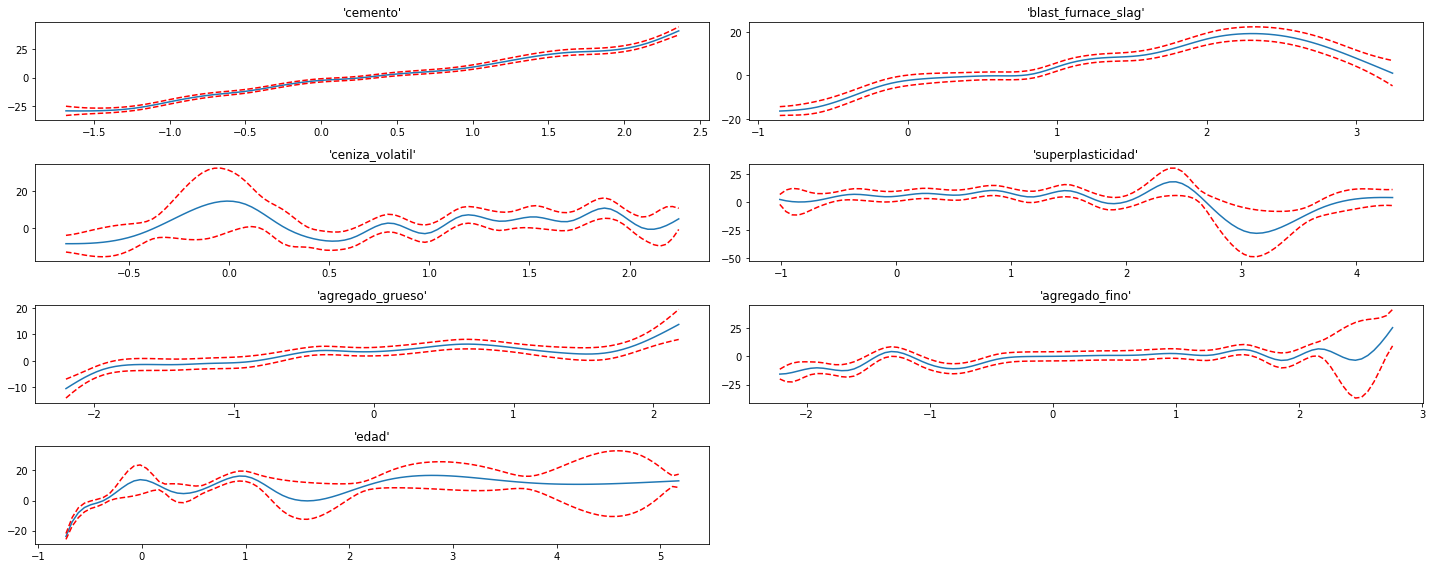

In [69]:
#Evaluamos el modelo elegido anteriormente para visualizar cada uno de los atributos predictores:
grilla_gam(gam)